In [1]:
%cd /content
!rm -rf *

/content


In [2]:
import torch
import torchvision

In [3]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1

In [4]:
def make_train_loader_test_loader(
    n_epochs = 3,
    batch_size_train = 64,
    batch_size_test = 1000,
    learning_rate = 0.01,
    momentum = 0.5,
    log_interval = 10,
    random_seed = 1):
  import torch
  import torchvision

  torch.backends.cudnn.enabled = False
  torch.manual_seed(random_seed)
  
  train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

  test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                              transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                  (0.1307,), (0.3081,))
                              ])),
    batch_size=batch_size_test, shuffle=True)
  return train_loader,test_loader

In [5]:
train_loader,test_loader = make_train_loader_test_loader()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

###Ok let's see what one test data batch consists of.



In [8]:
example_data.shape

torch.Size([1000, 1, 28, 28])

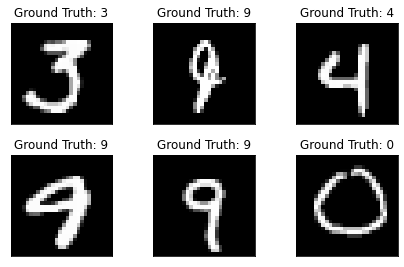

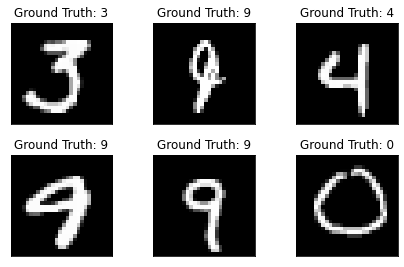

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

##Building the Network
Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam, Adagrad,RMSprop,Adadelta

### Для каждого оптимайзера свои параметры

```
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
```
* **model.parameters()** или Net
* **lr** - learning rate
* **momentum**- momentum factor (default: 0)



```
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, foreach=None, maximize=False, capturable=False, differentiable=False, fused=False)

```
* **model.parameters()** (iterable) – iterable of parameters to optimize or dicts defining parameter groups

* **lr** (float, optional) – learning rate (default: 1e-3)

* **betas** (Tuple[float, float], optional) – coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))

* **eps** (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)

* **weight_decay** (float, optional) – weight decay (L2 penalty) (default: 0)

* **amsgrad** (bool, optional) – whether to use the AMSGrad variant of this algorithm from the paper On the Convergence of Adam and Beyond (default: False)

* **foreach** (bool, optional) – whether foreach implementation of optimizer is used (default: None)

* **maximize** (bool, optional) – maximize the params based on the objective, instead of minimizing (default: False)

* **capturable** (bool, optional) – whether this instance is safe to capture in a CUDA graph. Passing True can impair ungraphed performance, so if you don’t intend to graph capture this instance, leave it False (default: False)

* **fused** (bool, optional) – whether fused implementation of optimizer is used. Currently, torch.float64, torch.float32, torch.float16, and torch.bfloat16 are supported. (default: False)


```
optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10, foreach=None, *, maximize=False)
```

```
optimizer = optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, foreach=None, maximize=False, differentiable=False)

```
```
optimizer = optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0, foreach=None, *, maximize=False)
```

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    def GetName(self):
      for i, j in globals().items():
        if j is self:
          return i


In [12]:
def make_model_optimizer_dict(model,optimizer,train_loader,n_epochs):
  return {
        "model":model,
        "optimizer":optimizer,
        "train_losses" : [],
        "train_counter" : [],
        "test_losses" : [],
        "test_counter" : [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    }

In [22]:
list_names = ['SGD','Adam','Adagrad','RMSprop','Adadelta']

optimizes = [SGD,Adam,Adagrad,RMSprop,Adadelta]
models = [Net()] * len(list_names)

optimizers = [optimizes[i](models[i].parameters(), lr=learning_rate) for i in range(len(list_names))]


model_optimizer_info = []
for i in range(len(list_names)):
    model_optimizer_dict = make_model_optimizer_dict(models[i],optimizers[i],train_loader,n_epochs)
    model_optimizer_info.append(model_optimizer_dict)

dict_of_models = dict(zip(list_names,model_optimizer_info))
dict_of_models

{'SGD': {'model': Net(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  ), 'optimizer': SGD (
  Parameter Group 0
      dampening: 0
      differentiable: False
      foreach: None
      lr: 0.01
      maximize: False
      momentum: 0
      nesterov: False
      weight_decay: 0
  ), 'train_losses': [], 'train_counter': [], 'test_losses': [], 'test_counter': [0,
   60000,
   120000,
   180000]},
 'Adam': {'model': Net(
    (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=320, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=10, bias=True)
  ), 'optimizer': Adam (

###Training the Model

In [14]:
import os
results = r'/content/results'
if not os.path.exists(results):
    os.makedirs(results)
for name in list_names:
  optim_dir = f'{results}/{name}'
  if not os.path.exists(optim_dir):
    os.makedirs(optim_dir)

In [23]:
# %mkdir /content/results
import time

def train(name,epoch):
  # 1
  model = dict_of_models[name]['model']
  optimizer = dict_of_models[name]['optimizer']
  train_losses = dict_of_models[name]['train_losses']
  train_counter = dict_of_models[name]['train_counter']
  test_losses = dict_of_models[name]['test_losses'] 
  test_counter = dict_of_models[name]['test_counter'] 
  # 2
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), f'/content/results/{name}/model.pth')
      torch.save(optimizer.state_dict(), f'/content/results/{name}/optimizer.pth')
      
def test(name,epoch):
  # 1
  model = dict_of_models[name]['model']
  optimizer = dict_of_models[name]['optimizer']
  train_losses = dict_of_models[name]['train_losses']
  train_counter = dict_of_models[name]['train_counter']
  test_losses = dict_of_models[name]['test_losses'] 
  test_counter = dict_of_models[name]['test_counter'] 
  # 2
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

###Training

In [24]:
def txtForPlot(
    train_losses,
    train_counter,
    test_losses,
    test_counter,
    pathToSave = '/content/results',
    name='SGD'):
  with open(f'{pathToSave}/{name}/train_losses.txt', "w") as output:
    output.write(str(train_losses))
  with open(f'{pathToSave}/{name}/train_counter.txt', "w") as output:
    output.write(str(train_counter))
  with open(f'{pathToSave}/{name}/test_losses.txt', "w") as output:
    output.write(str(test_losses))
  with open(f'{pathToSave}/{name}/test_counter.txt', "w") as output:
    output.write(str(test_counter))


def epochesTest(name,n_epochs):
    import time
    print(f'Optimizer: {name} - Start')
    startTime = time.time()
    test(name,0)
    for epoch in range(1, n_epochs + 1):
      train(name,epoch)
      test(name,epoch)
    
    print(f'Optimizer: {name} - End')
    _time = "{:.4f}".format(time.time() - startTime)
    print(f'Time:{_time} sec\n')

    txtForPlot(
    train_losses= dict_of_models[name]['train_losses'],
    train_counter = dict_of_models[name]['train_counter'],
    test_losses = dict_of_models[name]['test_losses'],
    test_counter = dict_of_models[name]['test_counter'],
    pathToSave = '/content/results',
    name=name)
  

In [25]:
for name in list_names:
  epochesTest(name,n_epochs)

Optimizer: SGD - Start


<ipython-input-11-8d1d56490e57>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3177, Accuracy: 962/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.342530
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.286739
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.323215
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.333163
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.307286
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.305812
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.310385
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.278212
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.273093
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.280014
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.275079
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.267797
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.194692
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.195996
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.217338
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.234331
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.217359
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.204694
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.172269
Train Epoch: 1 [12160/

And that's it. With just 3 epochs of training we already managed to achieve 97% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 10% accuracy on the test set before starting the training.

Let's plot our training curve.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as offline

import numpy as np

titles_names = [f'Plot {optimizer}' for optimizer in list_names]
# len(list_names), 1
fig = make_subplots(
    rows=len(list_names), cols=1,
    subplot_titles=titles_names)

for i in range(len(list_names)):
    name = list_names[i]
    with open(f'/content/results/{name}/train_losses.txt', 'r') as file:
        train_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
    
    with open(f'/content/results/{name}/train_counter.txt', 'r') as file:
        train_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))

    with open(f'/content/results/{name}/test_losses.txt', 'r') as file:
        test_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
    
    with open(f'/content/results/{name}/test_counter.txt', 'r') as file:
        test_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', '))) 

    
    fig.add_trace(go.Scatter(x=train_counter,y=train_losses),               
                  row=i+1, col=1)
    
    fig.add_scatter(
        x=test_counter,
        y=test_losses, 
        mode="markers",                
        marker=dict(size=20,color="LightSeaGreen"),                
        #name="a", 
        row=i+1, col=1)

fig.update_layout(height=500, width=700,
                  title_text="Optimizers")

fig.show()

In [ ]:
def showPlotly(name):
  from plotly.subplots import make_subplots
  import plotly.graph_objects as go
  import plotly.express as px
  import plotly.offline as offline

  import numpy as np

  with open(f'/content/results/{name}/train_losses.txt', 'r') as file:
      train_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
  
  with open(f'/content/results/{name}/train_counter.txt', 'r') as file:
      train_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))

  with open(f'/content/results/{name}/test_losses.txt', 'r') as file:
      test_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
  
  with open(f'/content/results/{name}/test_counter.txt', 'r') as file:
      test_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', '))) 

  fig = go.Figure()

  fig.add_trace(go.Scatter(x=train_counter,y=train_losses))
  
  fig.add_scatter(
      x=test_counter,
      y=test_losses, 
      mode="markers",                
      marker=dict(size=20,color="LightSeaGreen"),                
      #name="a", 
      #row=i+1, col=1
      )
  fig.show()
showPlotly('SGD')

In [ ]:
!pip3 install imgkit

In [ ]:
def saveToHTML(name):
  import os
  results = r'/content/results'
  if not os.path.exists(results):
      os.makedirs(results)

  plotsDir = f'{results}/plots'
  htmlDir = f'{results}/html'
  if not os.path.exists(plotsDir):
      os.makedirs(plotsDir)
  if not os.path.exists(htmlDir):
      os.makedirs(htmlDir)

  import plotly.graph_objects as go
  import plotly.express as px
  import plotly.offline as offline


  # for i in range(len(list_names)):
  name #= list_names[i]
  with open(f'/content/results/{name}/train_losses.txt', 'r') as file:
      train_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
  
  with open(f'/content/results/{name}/train_counter.txt', 'r') as file:
      train_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))

  with open(f'/content/results/{name}/test_losses.txt', 'r') as file:
      test_losses = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', ')))
  
  with open(f'/content/results/{name}/test_counter.txt', 'r') as file:
      test_counter = list(map(float,file.read().replace('\n', '').replace('[','').replace(']','').split(sep=', '))) 

  fig = go.Figure()

  fig.add_trace(go.Scatter(x=train_counter,y=train_losses))
  
  fig.add_scatter(
      x=test_counter,
      y=test_losses, 
      mode="markers",                
      marker=dict(size=20,color="LightSeaGreen"),                
      #name="a", 
      #row=i+1, col=1
      )
  
  offline.plot(fig, filename=f'{htmlDir}/{name}.html',auto_open=False)
for i in range(len(list_names)):
  name = list_names[i]
  saveToHTML(name)

Something usesfull
###Saving & Loading Model for Inference
##Save/Load state_dict (Recommended)
#Save:

`torch.save(model.state_dict(), PATH)`
#Load:
```
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```
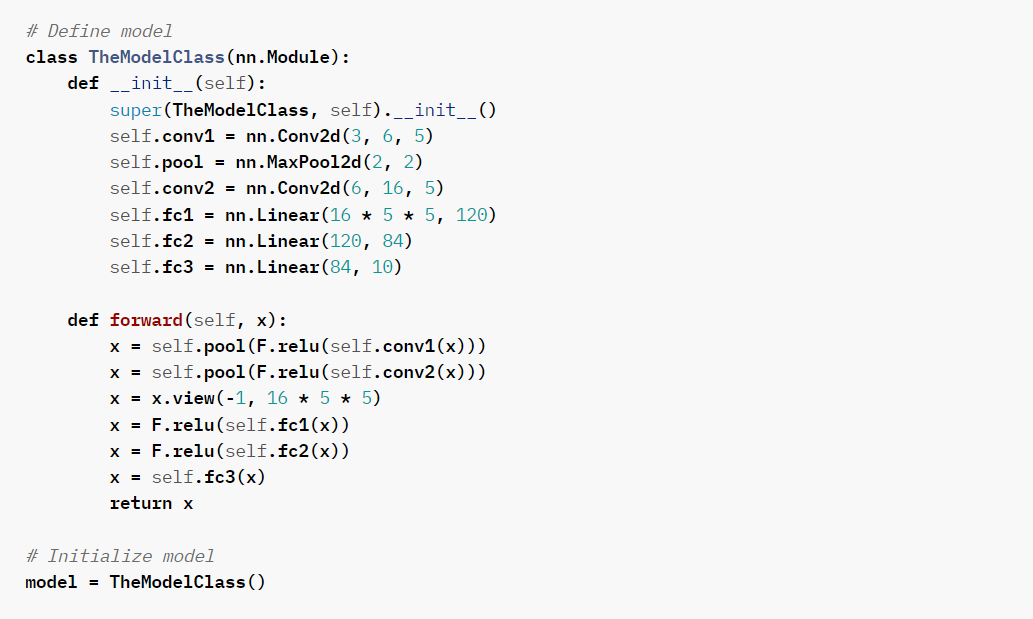
